In [2]:
!pip install datasets pennylane
from datasets import load_dataset

ds = load_dataset("mattymchen/mr")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 61.7 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 74.0 MB/s eta 0:00:00:00:0100:01


README.md:   0%|          | 0.00/688 [00:00<?, ?B/s]

data/test-00000-of-00001-1ad570418120a67(…):   0%|          | 0.00/884k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10662 [00:00<?, ? examples/s]

In [2]:
ds

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10662
    })
})

# **DistilBERT**

In [3]:
!pip install pennylane
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
import pennylane as qml
from pennylane import numpy as pnp
import re
import warnings
import re
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
# Label encoding for 'status' column
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
import pennylane as qml
# Convert data to PyTorch DataLoader format
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import ParameterSampler
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
import time
import random
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel

# ---------------------------
# Load MPQA Dataset
# ---------------------------
ds = load_dataset("mattymchen/mr")
# Convert train split to pandas (MPQA already split)
df = ds["test"].to_pandas()

print(df.head())
print(df.shape)

# MPQA typically has columns: 'text' and 'label'
# If column name is different, print df.columns to check.

# ---------------------------
# Basic Preprocessing
# ---------------------------

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)

# ---------------------------
# Remove Stopwords
# ---------------------------

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    statement = statement.lower()
    statement = re.sub(r'[^\w\s]', '', statement)
    statement = re.sub(r'\d+', '', statement)
    words = statement.split()
    words = [word for word in words if word not in stop_words]
    cleaned_statement = ' '.join(words)
    return cleaned_statement

df['cleaned_text'] = df['cleaned_text'].apply(clean_statement)

print(df.head())

# ---------------------------
# Label Encoding
# ---------------------------
# MPQA labels are usually already numeric (0,1)
# But we keep this step for safety

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

print(df['label'].value_counts())

# ---------------------------
# Balance Dataset
# ---------------------------

majority_class = df['label'].value_counts().idxmax()
minority_class = df['label'].value_counts().idxmin()

df_majority = df[df['label'] == majority_class]
df_minority = df[df['label'] == minority_class]

# Downsample majority
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Combine
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Class Distribution:")
print(df_balanced['label'].value_counts())

df_balanced.head()


# Initialize the tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokens = tokenizer.batch_encode_plus(
    df['cleaned_text'].tolist(),
    max_length=128,
    padding="max_length",   # <-- updated
    truncation=True,
    return_tensors="pt"
)

# Convert to tensors
input_ids = torch.tensor(tokens['input_ids'])
attention_masks = torch.tensor(tokens['attention_mask'])
labels = torch.tensor(df['label'].values)

# Split the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.2)


train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)

# Create a quantum node (circuit)
dev = qml.device("default.qubit", wires=2)  # or 'default.qubit'

@qml.qnode(dev)
@qml.qnode(dev)
def quantum_circuit(weights, inputs):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.RX(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)

    qml.CNOT(wires=[0, 1])

    qml.RZ(weights[0], wires=0)
    qml.RZ(weights[1], wires=1)

    return qml.expval(qml.PauliZ(0))

class QBiLSTM(nn.Module):
    def __init__(self):
        super(QBiLSTM, self).__init__()

        self.bert = AutoModel.from_pretrained("distilbert-base-uncased")

        # 🔁 BiLSTM instead of LSTM
        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        # 128 × 2 because BiLSTM
        self.fc = nn.Linear(256, 2)

    def quantum_layer(self, inputs):
        processed_features = []

        for feature_vector in inputs:
            features_for_quantum = feature_vector[:2]
            q_out = quantum_circuit(
                torch.randn(2, dtype=torch.float32),
                features_for_quantum
            )
            processed_features.append(q_out)

        return torch.stack(processed_features).unsqueeze(1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # BiLSTM output
        lstm_output, _ = self.bilstm(bert_output.last_hidden_state)

        # Last timestep (batch, 256)
        last_hidden = lstm_output[:, -1, :]

        _ = self.quantum_layer(last_hidden)

        # Classification
        output = self.fc(last_hidden)
        return output


model = QBiLSTM()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define hyperparameter search space
param_grid = {
    'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [3, 5, 7]
}

num_samples = 5  
param_list = list(ParameterSampler(param_grid, n_iter=num_samples, random_state=42))

best_model = None
best_val_accuracy = 0.0
best_params = None

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Loop through each random set of hyperparameters
for idx, params in enumerate(param_list):
    print(f"Testing configuration {idx + 1}: {params}")

    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # Move tensors to the same device
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        all_preds = []
        all_labels = []

        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # Move tensors to the same device
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_val_loss += loss.item()

                logits = outputs.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                total_val_accuracy += flat_accuracy(logits, label_ids)

                all_preds.extend(np.argmax(logits, axis=1).flatten())
                all_labels.extend(label_ids.flatten())

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"Time: {elapsed_time:.2f} seconds")

        # Save best model
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_model = model.state_dict()
            best_params = params
            torch.save(best_model, 'best_model.pth')
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))



# Define search space for hyperparameters
epochs = 5
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
optimizers = ['adamw', 'adam', 'rmsprop', 'sgd']

# Number of random samples to try
num_samples = 5

# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to get optimizer
def get_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'adamw':
        return optim.AdamW(model_parameters, lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr)

# Randomly sample hyperparameter combinations
random_hyperparams = [
    {
        "optimizer": random.choice(optimizers),
        "learning_rate": random.choice(learning_rates),
        "batch_size": random.choice(batch_sizes),
    }
    for _ in range(num_samples)
]

best_accuracy = 0
best_params = {}

# Iterate over randomly chosen hyperparameter sets
for params in random_hyperparams:
    optimizer_name = params["optimizer"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]

    # Initialize data loaders
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

    # Define optimizer and scheduler
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Move model to device
    model.to(device)

    for epoch in range(epochs):
        start_time = time.time()

        # Training
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_val_loss += loss.item()

                logits = outputs.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                total_val_accuracy += flat_accuracy(logits, label_ids)

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)

        elapsed_time = time.time() - start_time

        print(f"Optimizer: {optimizer_name} | Learning Rate: {lr} | Batch Size: {batch_size}")
        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"Time: {elapsed_time:.2f} seconds")
        print("-" * 50)

        # Update best parameters if validation accuracy improves
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {"optimizer": optimizer_name, "learning_rate": lr, "batch_size": batch_size}

print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: Optimizer = {best_params['optimizer']}, Learning Rate = {best_params['learning_rate']}, Batch Size = {best_params['batch_size']}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 59.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 101.7 MB/s eta 0:00:0000:0100:01
                                                text  label
0  with its dogged hollywood naturalism and the i...      0
1  . . . has its moments , but ultimately , its c...      0
2  leigh 's film is full of memorable performance...      1
3  the code talkers deserved better than a hollow...      0
4     i have to admit that i am baffled by jason x .      0
(10662, 2)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  label  \
0  with its dogged hollywood naturalism and the i...      0   
1  . . . has its moments , but ultimately , its c...      0   
2  leigh 's film is full of memorable performance...      1   
3  the code talkers deserved better than a hollow...      0   
4     i have to admit that i am baffled by jason x .      0   

                                        cleaned_text  
0  dogged hollywood naturalism inexorable passage...  
1  moments ultimately curmudgeon nt quite make cu...  
2  leigh film full memorable performances top bottom  
3        code talkers deserved better hollow tribute  
4                              admit baffled jason x  
label
0    5331
1    5331
Name: count, dtype: int64
Balanced Class Distribution:
label
0    10662
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2026-02-14 16:01:53.171983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771084913.522792      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771084913.626673      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771084914.509725      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771084914.509774      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771084914.509777      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Testing configuration 1: {'learning_rate': 1e-05, 'epochs': 7, 'batch_size': 16}
Epoch 1 | Train Loss: 0.6196 | Train Accuracy: 0.6436
Validation Loss: 0.5534 | Validation Accuracy: 0.7150
Time: 130.62 seconds
New best model saved with accuracy: 0.7150
Epoch 2 | Train Loss: 0.4906 | Train Accuracy: 0.7663
Validation Loss: 0.5121 | Validation Accuracy: 0.7534
Time: 137.91 seconds
New best model saved with accuracy: 0.7534
Epoch 3 | Train Loss: 0.4079 | Train Accuracy: 0.8144
Validation Loss: 0.5210 | Validation Accuracy: 0.7511
Time: 137.44 seconds
Epoch 4 | Train Loss: 0.3328 | Train Accuracy: 0.8606
Validation Loss: 0.5546 | Validation Accuracy: 0.7567
Time: 141.75 seconds
New best model saved with accuracy: 0.7567
Epoch 5 | Train Loss: 0.2766 | Train Accuracy: 0.8897
Validation Loss: 0.5869 | Validation Accuracy: 0.7595
Time: 143.96 seconds
New best model saved with accuracy: 0.7595
Epoch 6 | Train Loss: 0.2309 | Train Accuracy: 0.9151
Validation Loss: 0.6147 | Validation Accuracy: 0

===== Evaluation Metrics =====
Accuracy     : 0.7698
Precision    : 0.7749
Recall       : 0.7596
Sensitivity : 0.7596
Specificity : 0.7800
F1-score    : 0.7672
AUC         : 0.8392

===== Classification Report =====
              precision    recall  f1-score   support

           0     0.7649    0.7800    0.7724      1068
           1     0.7749    0.7596    0.7672      1065

    accuracy                         0.7698      2133
   macro avg     0.7699    0.7698    0.7698      2133
weighted avg     0.7699    0.7698    0.7698      2133



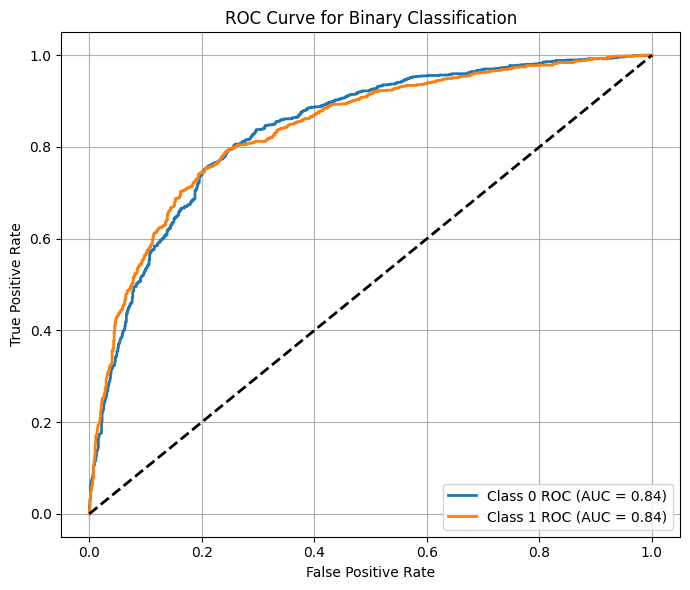

In [5]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve)
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_binary_model(model, dataloader, device):
    model.eval()
    all_true_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input_ids, b_input_mask)
            probs = torch.softmax(outputs, dim=1)

            all_true_labels.append(b_labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Convert to numpy
    all_true_labels = np.concatenate(all_true_labels)
    all_probs = np.concatenate(all_probs)
    all_preds = np.argmax(all_probs, axis=1)

    # ================= Metrics =================
    tn, fp, fn, tp = confusion_matrix(all_true_labels, all_preds).ravel()

    accuracy = accuracy_score(all_true_labels, all_preds)
    precision = precision_score(all_true_labels, all_preds)
    recall = recall_score(all_true_labels, all_preds)          # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(all_true_labels, all_preds)
    auc = roc_auc_score(all_true_labels, all_probs[:, 1])

    # ================= Print metrics =================
    print("===== Evaluation Metrics =====")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Sensitivity : {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1-score    : {f1:.4f}")
    print(f"AUC         : {auc:.4f}")

    # ================= Classification Report =================
    print("\n===== Classification Report =====")
    print(classification_report(all_true_labels, all_preds, digits=4))

    # ================= ROC Curve (Both Classes) =================
    fpr_0, tpr_0, _ = roc_curve(all_true_labels, all_probs[:, 0], pos_label=0)
    fpr_1, tpr_1, _ = roc_curve(all_true_labels, all_probs[:, 1], pos_label=1)

    auc_0 = roc_auc_score(1 - all_true_labels, all_probs[:, 0])
    auc_1 = roc_auc_score(all_true_labels, all_probs[:, 1])

    plt.figure(figsize=(7, 6))
    plt.plot(fpr_0, tpr_0, label=f"Class 0 ROC (AUC = {auc_0:.2f})", lw=2)
    plt.plot(fpr_1, tpr_1, label=f"Class 1 ROC (AUC = {auc_1:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Binary Classification")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, specificity, f1, auc


accuracy, precision, recall, specificity, f1, auc = evaluate_binary_model(
    model, val_dataloader, device
)

In [6]:

!pip install pennylane
# ===============================
# Imports & Setup
# ===============================
import re, warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pennylane as qml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)

from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW

import nltk
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
ds = load_dataset("mattymchen/mr")
# Convert train split to pandas (MPQA already split)
df = ds["test"].to_pandas()

# ===============================
# Dataset Preprocessing
# ===============================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

# Load your dataset
# Replace this with your own df loading if not already loaded
# df = pd.read_csv("your_dataset.csv")

df["cleaned_text"] = df["text"].astype(str).apply(clean_text)

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])
min_class = df["label"].value_counts().min()

# Balance classes
df_balanced = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(min_class, random_state=42))
      .sample(frac=1, random_state=42)
)

# Tokenize
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokens = tokenizer(
    df_balanced["cleaned_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df_balanced["label"].values)

X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    input_ids, labels, attention_mask, test_size=0.2, random_state=42
)

train_data = TensorDataset(X_train, m_train, y_train)
val_data = TensorDataset(X_val, m_val, y_val)

train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=16)
val_loader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=16)


# ===============================
# Quantum Circuits
# ===============================
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def qc1(weights, x):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([0,1])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc2(weights, x):
    qml.Hadamard(0)
    qml.RY(x[0], 0)
    qml.RX(x[1], 1)
    qml.CNOT([1,0])
    qml.RX(weights[0], 0)
    qml.RY(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc3(weights, x):
    for i in range(2):
        qml.Hadamard(i)
        qml.RX(x[i], i)
        qml.RY(weights[i], i)
        qml.RZ(weights[i], i)
    qml.CNOT([0,1])
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, interface="torch")
def qc4(weights, x):
    qml.Hadamard(0)
    qml.CNOT([0,1])
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([1,0])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))


QUANTUM_CIRCUITS = {
    "QC1": qc1,
    "QC2": qc2,
    "QC3": qc3,
    "QC4": qc4
}


# ===============================
# Hybrid QBiLSTM Model
# ===============================
class QBiLSTM(nn.Module):
    def __init__(self, quantum_circuit):
        super().__init__()
        self.qc = quantum_circuit
        self.q_weights = nn.Parameter(torch.randn(2))

        self.encoder = AutoModel.from_pretrained("distilbert-base-uncased")

        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        # Include quantum output
        self.fc = nn.Linear(256 + 1, 2)

    def quantum_layer(self, x):
        q_outs = []
        for v in x:
            vec = torch.tanh(v[:2]).detach().cpu() * np.pi
            q_val = self.qc(self.q_weights, vec)
            q_outs.append(q_val)
        q_outs = torch.stack(q_outs).unsqueeze(1)
        return q_outs.to(x.device).float()

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(input_ids, attention_mask).last_hidden_state
        lstm_out, _ = self.bilstm(enc)
        h = lstm_out[:, -1, :]
        q_feat = self.quantum_layer(h)
        combined = torch.cat([h, q_feat], dim=1)
        return self.fc(combined)


# ===============================
# Training & Evaluation
# ===============================
results = {}

for name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n====== Training {name} ======")

    model = QBiLSTM(qc).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    EPOCHS = 10

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_loader, 1):
            ids, mask, y = [b.to(device) for b in batch]
            optimizer.zero_grad()
            logits = model(ids, mask)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{EPOCHS} | Avg Loss: {total_loss/len(train_loader):.4f}")

    # -------------------------------
    # Evaluation
    # -------------------------------
    model.eval()
    preds, gold, probs = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            ids, mask, y = [b.to(device) for b in batch]
            logits = model(ids, mask)
            prob = torch.softmax(logits, dim=1)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            probs.extend(prob[:, 1].cpu().numpy())
            gold.extend(y.cpu().numpy())

    preds = np.array(preds)
    gold = np.array(gold)
    probs = np.array(probs)

    accuracy = accuracy_score(gold, preds)
    precision = precision_score(gold, preds)
    recall = recall_score(gold, preds)
    f1 = f1_score(gold, preds)
    auc = roc_auc_score(gold, probs)
    tn, fp, fn, tp = confusion_matrix(gold, preds).ravel()
    specificity = tn / (tn + fp)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1": f1,
        "AUC": auc
    }

    print(f"\n{name} Results:")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Specificity  : {specificity:.4f}")
    print(f"F1-score     : {f1:.4f}")
    print(f"AUC          : {auc:.4f}")


# ===============================
# Final Comparison Table
# ===============================
print("\n===== FINAL QUANTUM CIRCUIT COMPARISON =====")
for k, v in results.items():
    print(f"\n{k}")
    for metric, value in v.items():
        print(f"{metric:12s}: {value:.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using device: cuda


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



====== Training QC1 ======
Epoch 1/10 | Avg Loss: 0.5144
Epoch 2/10 | Avg Loss: 0.3376
Epoch 3/10 | Avg Loss: 0.1824
Epoch 4/10 | Avg Loss: 0.0954
Epoch 5/10 | Avg Loss: 0.0568
Epoch 6/10 | Avg Loss: 0.0400
Epoch 7/10 | Avg Loss: 0.0330
Epoch 8/10 | Avg Loss: 0.0261
Epoch 9/10 | Avg Loss: 0.0181
Epoch 10/10 | Avg Loss: 0.0185

QC1 Results:
Accuracy     : 0.8036
Precision    : 0.8256
Recall       : 0.7546
Specificity  : 0.8497
F1-score     : 0.7885
AUC          : 0.8794

====== Training QC2 ======
Epoch 1/10 | Avg Loss: 0.5256
Epoch 2/10 | Avg Loss: 0.3539
Epoch 3/10 | Avg Loss: 0.1937
Epoch 4/10 | Avg Loss: 0.0997
Epoch 5/10 | Avg Loss: 0.0615
Epoch 6/10 | Avg Loss: 0.0448
Epoch 7/10 | Avg Loss: 0.0324
Epoch 8/10 | Avg Loss: 0.0281
Epoch 9/10 | Avg Loss: 0.0168
Epoch 10/10 | Avg Loss: 0.0217

QC2 Results:
Accuracy     : 0.8050
Precision    : 0.7874
Recall       : 0.8193
Specificity  : 0.7914
F1-score     : 0.8030
AUC          : 0.8826

====== Training QC3 ======
Epoch 1/10 | Avg Loss:

In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Evaluation
model.eval()
preds, gold, probs = [], [], []

with torch.no_grad():
    for batch in val_loader:
        ids, mask, y = [b.to(device) for b in batch]
        logits = model(ids, mask)

        probabilities = torch.softmax(logits, dim=1)

        preds.extend(torch.argmax(logits, 1).cpu().numpy())
        probs.extend(probabilities[:, 1].cpu().numpy())  # positive class prob
        gold.extend(y.cpu().numpy())

# Convert to numpy
preds = np.array(preds)
gold = np.array(gold)
probs = np.array(probs)

# Basic metrics
accuracy = accuracy_score(gold, preds)
precision = precision_score(gold, preds)
recall = recall_score(gold, preds)
f1 = f1_score(gold, preds)
auc = roc_auc_score(gold, probs)

# Confusion Matrix for Specificity
tn, fp, fn, tp = confusion_matrix(gold, preds).ravel()
specificity = tn / (tn + fp)

# Store results
results[name] = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "Specificity": specificity,
    "F1": f1,
    "AUC": auc
}

# Print nicely
print(f"\n{name} Results:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Specificity  : {specificity:.4f}")
print(f"F1-score     : {f1:.4f}")
print(f"AUC          : {auc:.4f}")
print("\n===== FINAL QUANTUM CIRCUIT COMPARISON =====")

for k, v in results.items():
    print(f"\n{k}")

    if isinstance(v, dict):
        for metric, value in v.items():
            print(f"{metric:12s}: {value:.4f}")
    else:
        print(f"Accuracy: {v:.4f}")


QC4 Results:
Accuracy     : 0.7947
Precision    : 0.8404
Recall       : 0.7121
Specificity  : 0.8725
F1-score     : 0.7709
AUC          : 0.8800

===== FINAL QUANTUM CIRCUIT COMPARISON =====

QC1
Accuracy    : 0.8036
Precision   : 0.8256
Recall      : 0.7546
Specificity : 0.8497
F1          : 0.7885
AUC         : 0.8794

QC2
Accuracy    : 0.8050
Precision   : 0.7874
Recall      : 0.8193
Specificity : 0.7914
F1          : 0.8030
AUC         : 0.8826

QC3
Accuracy    : 0.7928
Precision   : 0.7469
Recall      : 0.8667
Specificity : 0.7231
F1          : 0.8023
AUC         : 0.8847

QC4
Accuracy    : 0.7947
Precision   : 0.8404
Recall      : 0.7121
Specificity : 0.8725
F1          : 0.7709
AUC         : 0.8800


# **DeBARTA**

In [6]:
!pip install pennylane
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
import pennylane as qml
from pennylane import numpy as pnp
import re
import warnings
import re
import nltk

from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
# Label encoding for 'status' column
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
import pennylane as qml
# Convert data to PyTorch DataLoader format
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import ParameterSampler
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
import time
import random
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
import nltk
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
ds = load_dataset("mattymchen/mr")
# Convert train split to pandas (MPQA already split)
df = ds["test"].to_pandas()

# ===============================
# Dataset Preprocessing
# ===============================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

# Load your dataset
# Replace this with your own df loading if not already loaded
# df = pd.read_csv("your_dataset.csv")

df["cleaned_text"] = df["text"].astype(str).apply(clean_text)

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])
min_class = df["label"].value_counts().min()

# Balance classes
df_balanced = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(min_class, random_state=42))
      .sample(frac=1, random_state=42)
)


# Initialize the tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

tokens = tokenizer.batch_encode_plus(
    df['cleaned_text'].tolist(),
    max_length=128,
    padding="max_length",   # <-- updated
    truncation=True,
    return_tensors="pt"
)

# Convert to tensors
input_ids = torch.tensor(tokens['input_ids'])
attention_masks = torch.tensor(tokens['attention_mask'])
labels = torch.tensor(df['label'].values)

# Split the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.2)


train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)

# Create a quantum node (circuit)
dev = qml.device("default.qubit", wires=2)  # or 'default.qubit'

@qml.qnode(dev)
def quantum_circuit(weights, inputs):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.RX(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)

    qml.CNOT(wires=[0, 1])

    qml.RZ(weights[0], wires=0)
    qml.RZ(weights[1], wires=1)

    return qml.expval(qml.PauliZ(0))

class QBiLSTM(nn.Module):
    def __init__(self):
        super(QBiLSTM, self).__init__()

        self.bert = AutoModel.from_pretrained("microsoft/deberta-v3-base")

        # 🔁 BiLSTM instead of LSTM
        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        # 128 × 2 because BiLSTM
        self.fc = nn.Linear(256, 2)

    def quantum_layer(self, inputs):
        processed_features = []

        for feature_vector in inputs:
            features_for_quantum = feature_vector[:2]
            q_out = quantum_circuit(
                torch.randn(2, dtype=torch.float32),
                features_for_quantum
            )
            processed_features.append(q_out)

        return torch.stack(processed_features).unsqueeze(1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # BiLSTM output
        lstm_output, _ = self.bilstm(bert_output.last_hidden_state)

        # Last timestep (batch, 256)
        last_hidden = lstm_output[:, -1, :]

        _ = self.quantum_layer(last_hidden)

        # Classification
        output = self.fc(last_hidden)
        return output


model = QBiLSTM()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define hyperparameter search space
param_grid = {
    'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [3, 5, 7]
}

num_samples = 5  
param_list = list(ParameterSampler(param_grid, n_iter=num_samples, random_state=42))

best_model = None
best_val_accuracy = 0.0
best_params = None

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Loop through each random set of hyperparameters
for idx, params in enumerate(param_list):
    print(f"Testing configuration {idx + 1}: {params}")

    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # Move tensors to the same device
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        all_preds = []
        all_labels = []

        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # Move tensors to the same device
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_val_loss += loss.item()

                logits = outputs.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                total_val_accuracy += flat_accuracy(logits, label_ids)

                all_preds.extend(np.argmax(logits, axis=1).flatten())
                all_labels.extend(label_ids.flatten())

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"Time: {elapsed_time:.2f} seconds")

        # Save best model
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_model = model.state_dict()
            best_params = params
            torch.save(best_model, 'best_model.pth')
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))



# Define search space for hyperparameters
epochs = 5
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
optimizers = ['adamw', 'adam', 'rmsprop', 'sgd']

# Number of random samples to try
num_samples = 5

# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to get optimizer
def get_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'adamw':
        return optim.AdamW(model_parameters, lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr)

# Randomly sample hyperparameter combinations
random_hyperparams = [
    {
        "optimizer": random.choice(optimizers),
        "learning_rate": random.choice(learning_rates),
        "batch_size": random.choice(batch_sizes),
    }
    for _ in range(num_samples)
]

best_accuracy = 0
best_params = {}

# Iterate over randomly chosen hyperparameter sets
for params in random_hyperparams:
    optimizer_name = params["optimizer"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]

    # Initialize data loaders
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

    # Define optimizer and scheduler
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Move model to device
    model.to(device)

    for epoch in range(epochs):
        start_time = time.time()

        # Training
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_val_loss += loss.item()

                logits = outputs.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                total_val_accuracy += flat_accuracy(logits, label_ids)

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)

        elapsed_time = time.time() - start_time

        print(f"Optimizer: {optimizer_name} | Learning Rate: {lr} | Batch Size: {batch_size}")
        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"Time: {elapsed_time:.2f} seconds")
        print("-" * 50)

        # Update best parameters if validation accuracy improves
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {"optimizer": optimizer_name, "learning_rate": lr, "batch_size": batch_size}

print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: Optimizer = {best_params['optimizer']}, Learning Rate = {best_params['learning_rate']}, Batch Size = {best_params['batch_size']}")


Using device: cuda


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

2026-02-15 06:47:03.291696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771138023.465173      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771138023.514330      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771138023.949009      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771138023.949051      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771138023.949054      55 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Testing configuration 1: {'learning_rate': 1e-05, 'epochs': 7, 'batch_size': 16}
Epoch 1 | Train Loss: 0.6952 | Train Accuracy: 0.5089
Validation Loss: 0.6922 | Validation Accuracy: 0.5512
Time: 180.25 seconds
New best model saved with accuracy: 0.5512
Epoch 2 | Train Loss: 0.6492 | Train Accuracy: 0.6190
Validation Loss: 0.5176 | Validation Accuracy: 0.7630
Time: 177.53 seconds
New best model saved with accuracy: 0.7630
Epoch 3 | Train Loss: 0.4877 | Train Accuracy: 0.7800
Validation Loss: 0.4699 | Validation Accuracy: 0.7866
Time: 177.09 seconds
New best model saved with accuracy: 0.7866
Epoch 4 | Train Loss: 0.4149 | Train Accuracy: 0.8173
Validation Loss: 0.4670 | Validation Accuracy: 0.7915
Time: 176.89 seconds
New best model saved with accuracy: 0.7915
Epoch 5 | Train Loss: 0.3660 | Train Accuracy: 0.8473
Validation Loss: 0.4487 | Validation Accuracy: 0.7877
Time: 176.70 seconds
Epoch 6 | Train Loss: 0.3359 | Train Accuracy: 0.8638
Validation Loss: 0.4721 | Validation Accuracy: 0

===== Evaluation Metrics =====
Accuracy     : 0.7731
Precision    : 0.7812
Recall       : 0.7547
Sensitivity : 0.7547
Specificity : 0.7912
F1-score    : 0.7678
AUC         : 0.8334

===== Classification Report =====
              precision    recall  f1-score   support

           0     0.7656    0.7912    0.7782      1073
           1     0.7812    0.7547    0.7678      1060

    accuracy                         0.7731      2133
   macro avg     0.7734    0.7730    0.7730      2133
weighted avg     0.7734    0.7731    0.7730      2133



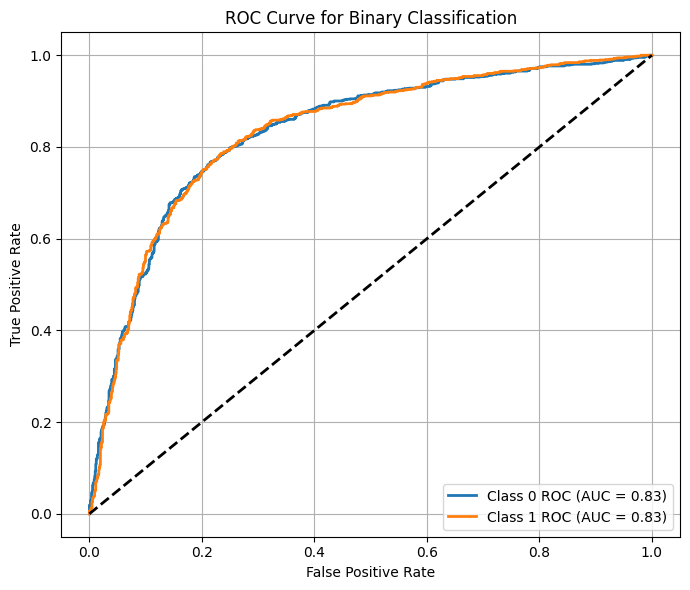

In [7]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_binary_model(model, dataloader, device):
    model.eval()
    all_true_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input_ids, b_input_mask)
            probs = torch.softmax(outputs, dim=1)

            all_true_labels.append(b_labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Convert to numpy
    all_true_labels = np.concatenate(all_true_labels)
    all_probs = np.concatenate(all_probs)
    all_preds = np.argmax(all_probs, axis=1)

    # ================= Metrics =================
    tn, fp, fn, tp = confusion_matrix(all_true_labels, all_preds).ravel()

    accuracy = accuracy_score(all_true_labels, all_preds)
    precision = precision_score(all_true_labels, all_preds)
    recall = recall_score(all_true_labels, all_preds)          # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(all_true_labels, all_preds)
    auc = roc_auc_score(all_true_labels, all_probs[:, 1])

    # ================= Print metrics =================
    print("===== Evaluation Metrics =====")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Sensitivity : {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1-score    : {f1:.4f}")
    print(f"AUC         : {auc:.4f}")

    # ================= Classification Report =================
    print("\n===== Classification Report =====")
    print(classification_report(all_true_labels, all_preds, digits=4))

    # ================= ROC Curve (Both Classes) =================
    fpr_0, tpr_0, _ = roc_curve(all_true_labels, all_probs[:, 0], pos_label=0)
    fpr_1, tpr_1, _ = roc_curve(all_true_labels, all_probs[:, 1], pos_label=1)

    auc_0 = roc_auc_score(1 - all_true_labels, all_probs[:, 0])
    auc_1 = roc_auc_score(all_true_labels, all_probs[:, 1])

    plt.figure(figsize=(7, 6))
    plt.plot(fpr_0, tpr_0, label=f"Class 0 ROC (AUC = {auc_0:.2f})", lw=2)
    plt.plot(fpr_1, tpr_1, label=f"Class 1 ROC (AUC = {auc_1:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Binary Classification")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, specificity, f1, auc


accuracy, precision, recall, specificity, f1, auc = evaluate_binary_model(
    model, val_dataloader, device
)

In [5]:
# =====================================
# 1. Imports
# =====================================
import re, warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pennylane as qml

from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================================
# 2. Load Dataset (Binary Sentiment)
# =====================================
ds = load_dataset("mattymchen/mr")
# Convert train split to pandas (MPQA already split)
df = ds["test"].to_pandas()

print("Dataset shape:", df.shape)

# =====================================
# 3. Preprocessing
# =====================================
# ===============================
# Dataset Preprocessing
# ===============================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

df["cleaned_text"] = df["text"].astype(str).apply(clean_text)

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])
min_class = df["label"].value_counts().min()

# Balance classes
df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(min_class, random_state=42))
      .sample(frac=1, random_state=42)
)

# =====================================
# 4. Tokenization
# =====================================
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

tokens = tokenizer(
    df["cleaned_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df["label"].values)

X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    input_ids, labels, attention_mask,
    test_size=0.2, random_state=42
)

train_data = TensorDataset(X_train, m_train, y_train)
val_data   = TensorDataset(X_val, m_val, y_val)

# =====================================
# 5. Quantum Circuits
# =====================================
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def qc1(weights, x):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([0, 1])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc2(weights, x):
    qml.Hadamard(0)
    qml.RY(x[0], 0)
    qml.RX(x[1], 1)
    qml.CNOT([1, 0])
    qml.RX(weights[0], 0)
    qml.RY(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc3(weights, x):
    for i in range(2):
        qml.Hadamard(i)
        qml.RX(x[i], i)
        qml.RY(weights[i], i)
        qml.RZ(weights[i], i)
    qml.CNOT([0, 1])
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, interface="torch")
def qc4(weights, x):
    qml.Hadamard(0)
    qml.CNOT([0, 1])
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([1, 0])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

QUANTUM_CIRCUITS = {
    "QC1": qc1,
    "QC2": qc2,
    "QC3": qc3,
    "QC4": qc4
}

# =====================================
# 6. QBiLSTM Model
# =====================================
class QBiLSTM(nn.Module):
    def __init__(self, quantum_circuit):
        super().__init__()

        self.qc = quantum_circuit
        self.q_weights = nn.Parameter(torch.randn(2))

        self.encoder = AutoModel.from_pretrained("microsoft/deberta-v3-base")

        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(257, 2)

    def quantum_layer(self, x):
        q_out = [self.qc(self.q_weights, v[:2]) for v in x]
        q_out = torch.stack(q_out)
        q_out = q_out.float()
        return q_out.unsqueeze(1)

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state

        lstm_out, _ = self.bilstm(enc)
        h = lstm_out[:, -1, :]

        q_feat = self.quantum_layer(h)
        h = torch.cat([h, q_feat], dim=1)

        return self.fc(h)

# =====================================
# 7. Training + Evaluation
# =====================================
def train_and_validate(model, params):

    train_loader = DataLoader(train_data, batch_size=params["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=params["batch_size"])

    optimizer = AdamW(model.parameters(), lr=params["learning_rate"])
    loss_fn = nn.CrossEntropyLoss()

    total_steps = len(train_loader) * params["epochs"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 0, total_steps
    )

    # Training
    for _ in range(params["epochs"]):
        model.train()
        for ids, mask, y in train_loader:
            ids, mask, y = ids.to(device), mask.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(ids, mask)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Evaluation
    model.eval()
    preds, gold, probs = [], [], []

    with torch.no_grad():
        for ids, mask, y in val_loader:
            ids, mask = ids.to(device), mask.to(device)
            logits = model(ids, mask)

            softmax = torch.softmax(logits, dim=1)
            preds.extend(torch.argmax(logits, 1).cpu().numpy())
            probs.extend(softmax[:,1].cpu().numpy())
            gold.extend(y.numpy())

    acc = accuracy_score(gold, preds)
    prec = precision_score(gold, preds)
    recall = recall_score(gold, preds)
    f1 = f1_score(gold, preds)
    auc = roc_auc_score(gold, probs)

    tn, fp, fn, tp = confusion_matrix(gold, preds).ravel()
    specificity = tn / (tn + fp)

    return acc, prec, recall, specificity, f1, auc

# =====================================
# 8. Run All 4 Models
# =====================================
params = {
    "learning_rate": 2e-5,
    "batch_size": 16,
    "epochs": 5
}

final_results = {}

for name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n===== Training {name} =====")

    model = QBiLSTM(qc).to(device)
    metrics = train_and_validate(model, params)

    final_results[name] = metrics

# =====================================
# 9. Final Comparison
# =====================================
print("\n===== FINAL RESULTS =====")
print("Model | Accuracy | Precision | Sensitivity | Specificity | F1 | AUC")

for k, v in final_results.items():
    print(f"{k} | {v[0]:.4f} | {v[1]:.4f} | {v[2]:.4f} | {v[3]:.4f} | {v[4]:.4f} | {v[5]:.4f}")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset shape: (10662, 2)

===== Training QC1 =====

===== Training QC2 =====

===== Training QC3 =====

===== Training QC4 =====

===== FINAL RESULTS =====
Model | Accuracy | Precision | Sensitivity | Specificity | F1 | AUC
QC1 | 0.8594 | 0.8523 | 0.8589 | 0.8597 | 0.8556 | 0.9271
QC2 | 0.8486 | 0.8483 | 0.8377 | 0.8588 | 0.8430 | 0.9177
QC3 | 0.8514 | 0.8485 | 0.8444 | 0.8579 | 0.8465 | 0.9255
QC4 | 0.8444 | 0.8484 | 0.8271 | 0.8607 | 0.8376 | 0.8972


In [9]:
import random
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch import optim

epochs = 5
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
optimizers = ['adamw', 'adam', 'rmsprop', 'sgd']
num_samples = 5
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def get_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'adamw':
        return optim.AdamW(model_parameters, lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr)
final_results = {}

for qc_name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n==============================")
    print(f" Quantum Circuit: {qc_name}")
    print(f"==============================")

    best_accuracy = 0
    best_params = None

    # Random hyperparameter sampling
    random_hyperparams = [
        {
            "optimizer": random.choice(optimizers),
            "learning_rate": random.choice(learning_rates),
            "batch_size": random.choice(batch_sizes),
        }
        for _ in range(num_samples)
    ]

    for params in random_hyperparams:
        optimizer_name = params["optimizer"]
        lr = params["learning_rate"]
        batch_size = params["batch_size"]

        print(f"\n Testing {params}")

        # Fresh model for each trial (VERY IMPORTANT)
        model = QBiLSTM(qc).to(device)

        train_dataloader = DataLoader(
            train_data,
            sampler=RandomSampler(train_data),
            batch_size=batch_size
        )

        val_dataloader = DataLoader(
            val_data,
            sampler=SequentialSampler(val_data),
            batch_size=batch_size
        )

        optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
        loss_fn = nn.CrossEntropyLoss()

        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # ===== Training =====
        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            total_train_accuracy = 0

            for batch in train_dataloader:
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)

                optimizer.zero_grad()
                outputs = model(b_input_ids, b_input_mask)
                loss = loss_fn(outputs, b_labels)

                total_train_loss += loss.item()
                logits = outputs.detach().cpu().numpy()
                total_train_accuracy += flat_accuracy(logits, b_labels.cpu().numpy())

                loss.backward()
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_train_loss / len(train_dataloader)
            avg_train_accuracy = total_train_accuracy / len(train_dataloader)

            # ===== Validation =====
            model.eval()
            total_val_accuracy = 0
            total_val_loss = 0

            with torch.no_grad():
                for batch in val_dataloader:
                    b_input_ids, b_input_mask, b_labels = batch
                    b_input_ids = b_input_ids.to(device)
                    b_input_mask = b_input_mask.to(device)
                    b_labels = b_labels.to(device)

                    outputs = model(b_input_ids, b_input_mask)
                    loss = loss_fn(outputs, b_labels)

                    total_val_loss += loss.item()
                    logits = outputs.detach().cpu().numpy()
                    total_val_accuracy += flat_accuracy(logits, b_labels.cpu().numpy())

            avg_val_accuracy = total_val_accuracy / len(val_dataloader)

            print(
                f"Epoch {epoch+1} | "
                f"Train Acc: {avg_train_accuracy:.4f} | "
                f"Val Acc: {avg_val_accuracy:.4f}"
            )

        # ===== Track best =====
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {
                "optimizer": optimizer_name,
                "learning_rate": lr,
                "batch_size": batch_size
            }

    final_results[qc_name] = {
        "best_accuracy": best_accuracy,
        "best_params": best_params
    }

    print(f"\n BEST for {qc_name}: {best_accuracy:.4f}")
    print(f" PARAMS: {best_params}")

print("\n===== FINAL QUANTUM CIRCUIT COMPARISON =====")
for qc, res in final_results.items():
    print(
        f"{qc} | Accuracy: {res['best_accuracy']:.4f} | "
        f"Params: {res['best_params']}"
    )


 Quantum Circuit: QC1

 Testing {'optimizer': 'adam', 'learning_rate': 5e-05, 'batch_size': 32}
Epoch 1 | Train Acc: 0.5275 | Val Acc: 0.6574
Epoch 2 | Train Acc: 0.5700 | Val Acc: 0.6531
Epoch 3 | Train Acc: 0.5130 | Val Acc: 0.4854
Epoch 4 | Train Acc: 0.5017 | Val Acc: 0.5146
Epoch 5 | Train Acc: 0.5025 | Val Acc: 0.4854

 Testing {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 16}
Epoch 1 | Train Acc: 0.5160 | Val Acc: 0.5132
Epoch 2 | Train Acc: 0.5144 | Val Acc: 0.5132
Epoch 3 | Train Acc: 0.5499 | Val Acc: 0.5160
Epoch 4 | Train Acc: 0.6007 | Val Acc: 0.6991
Epoch 5 | Train Acc: 0.7756 | Val Acc: 0.7690

 Testing {'optimizer': 'adamw', 'learning_rate': 3e-05, 'batch_size': 32}
Epoch 1 | Train Acc: 0.6256 | Val Acc: 0.7572
Epoch 2 | Train Acc: 0.7976 | Val Acc: 0.8391
Epoch 3 | Train Acc: 0.8671 | Val Acc: 0.8435
Epoch 4 | Train Acc: 0.9059 | Val Acc: 0.8412
Epoch 5 | Train Acc: 0.9398 | Val Acc: 0.8512

 Testing {'optimizer': 'adamw', 'learning_rate': 3e-05, 'batch_

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

# ----- Evaluation function -----
def evaluate_model(model, dataloader, num_classes):
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)

            outputs = model(b_input_ids, b_input_mask)

            all_logits.append(outputs.cpu())
            all_labels.append(b_labels)

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    # ---- Metrics ----
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    sensitivity = recall_score(labels, preds, average="macro")  # Recall
    f1 = f1_score(labels, preds, average="macro")

    # ---- Specificity ----
    cm = confusion_matrix(labels, preds)
    specificity_per_class = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity_per_class.append(tn / (tn + fp + 1e-9))
    specificity = np.mean(specificity_per_class)

    # ---- AUC ----
    if num_classes == 2:
        auc = roc_auc_score(labels, probs[:, 1])  # binary case
    else:
        labels_bin = label_binarize(labels, classes=list(range(num_classes)))
        auc = roc_auc_score(labels_bin, probs, average="macro", multi_class="ovr")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "f1": f1,
        "auc": auc,
        "labels": labels,
        "probs": probs
    }

# ----- Number of classes -----
num_classes = len(torch.unique(train_data.tensors[2]))  # or 2 for binary

best_models_results = {}

# ----- Evaluate each best model -----
for qc_name, res in final_results.items():
    print(f"\nEvaluating BEST model for {qc_name}")

    params = res["best_params"]

    # Fresh model
    model = QBiLSTM(QUANTUM_CIRCUITS[qc_name]).to(device)

    train_loader = DataLoader(
        train_data,
        sampler=RandomSampler(train_data),
        batch_size=params["batch_size"]
    )

    val_loader = DataLoader(
        val_data,
        sampler=SequentialSampler(val_data),
        batch_size=params["batch_size"]
    )

    optimizer = get_optimizer(params["optimizer"], model.parameters(), params["learning_rate"])
    loss_fn = nn.CrossEntropyLoss()

    # ---- Retrain ----
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = loss_fn(outputs, b_labels)
            loss.backward()
            optimizer.step()

    # ---- Final Evaluation ----
    metrics = evaluate_model(model, val_loader, num_classes)
    best_models_results[qc_name] = metrics

# ----- Print Summary Table -----
print("\n===== FINAL PERFORMANCE COMPARISON =====")
print("Model | Accuracy | Precision | Sensitivity | Specificity | F1 | AUC")
print("-"*75)
for qc, m in best_models_results.items():
    print(f"{qc} | {m['accuracy']:.4f} | {m['precision']:.4f} | {m['sensitivity']:.4f} | {m['specificity']:.4f} | {m['f1']:.4f} | {m['auc']:.4f}")

# ----- Plot ROC Curves -----
for qc, m in best_models_results.items():
    labels = m["labels"]
    probs = m["probs"]

    plt.figure(figsize=(7,6))
    if num_classes == 2:
        fpr, tpr, _ = roc_curve(labels, probs[:,1])
        auc_score = roc_auc_score(labels, probs[:,1])
        plt.plot(fpr, tpr, label=f"AUC={auc_score:.3f}")
    else:
        labels_bin = label_binarize(labels, classes=list(range(num_classes)))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
            auc_i = roc_auc_score(labels_bin[:, i], probs[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc_i:.3f})")

    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {qc}")
    plt.legend()
    plt.grid(True)
    plt.show()
